In [1]:
import glob
import numpy as np
import pandas as pd
import cv2
import random 
import math
import os
import ipynb
import importlib
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import transforms, utils
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.datasets as datasets
from skimage import transform
from torch.autograd import Variable

In [2]:
import ipynb.fs.full.BeeDataHandler as BeeDataHandler

In [3]:
importlib.reload(BeeDataHandler)

<module 'ipynb.fs.full.BeeDataHandler' (/Users/dieumynguyen/Documents/S2019_ObjectOrientedDesign/PyTorchPresentation/BeeHealthClassification_orig/BeeDataHandler.ipynb)>

### Parameters

In [6]:
IMG_SIZE = 32
BATCH_SIZE = 4
BW = True
num_epochs = 100
learning_rate = 0.001

bee_dir = '/Users/dieumynguyen/Datasets/HoneyBees'

### Define transformations for data augmentation

In [7]:
transform_list = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomRotation(degrees=180),
    transforms.RandomAffine(degrees=180, translate=(0, 0.2)),
    transforms.RandomHorizontalFlip(p=1),
    transforms.RandomVerticalFlip(p=1),
    transforms.ToTensor(),  # Always need, div by 255 
    BeeDataHandler.CustomNormalize()
])

### Load data

In [8]:
# Wrapper around the data
# Could load data into np or a pointer/filepath
bee_data_src = BeeDataHandler.DataHandler(bee_dir, transforms=transform_list, bw=BW, test_split=0.2)

In [9]:
train_dataloader = DataLoader(bee_data_src, batch_size=BATCH_SIZE, sampler=bee_data_src.train_sampler)
test_dataloader = DataLoader(bee_data_src, batch_size=BATCH_SIZE, sampler=bee_data_src.test_sampler)

In [10]:
def sample_imgs():
    xxx = (X + 1) / 2.0
    grid_img = utils.make_grid(xxx)

    fig, ax = plt.subplots(figsize=(12,12))
    ax.imshow(grid_img.permute(1,2,0))
    recovered_labels = [bee_data_src.idx_to_key[ele.item()] for ele in y]
    title_str = ""
    for recovered_label in recovered_labels:
        title_str += f"{recovered_label}                     "
    title_str = title_str[:-3]
    plt.title(title_str)

### CNN

$$ out = \frac{in - k + 2*P}{stride} + 1$$

$$ in = [(in - k + 2P) / S] + 1$$ 
$$ P = (S(in - 1) - in + k ) / 2$$ 
$$ P = (S*in - S - in + k ) / 2$$ 
$$ P = (in(S - 1) - S + k ) / 2$$ 

if S == 1:
$$ P = (k-S) / 2$$ 

In [11]:
def calculate_padding_for_SAME(in_size, k_size, stride=1):
    padding = (in_size * ( stride - 1) - stride + k_size) / 2 
    return int(padding)

In [12]:
def calculate_output_dimension(in_size, k_size, padding, stride=1):
    out_size = int(np.floor((in_size - k_size + 2*padding)/stride)) + 1
    return out_size

In [11]:
class CNN(nn.Module):
    
    def __init__(self, num_classes, num_in_channels, input_dim=IMG_SIZE):
        '''
        In this constructor, define layers using provided modiles from nn package.
        A Sequential is defined by a sequence of a layer, normalization, activation, pooling.
        '''
        super(CNN, self).__init__()
        
        num_kernels = [5, 10]
        k_sizes = [3, 3]
        
        
        """ CONV LAYER 1 """
        """ ---------------------------------------- """
        padding_1 = calculate_padding_for_SAME(input_dim, k_size=k_sizes[0])     
        print("padding_1: ", padding_1)
        self.layer1 = nn.Sequential(
            nn.Conv2d(num_in_channels, num_kernels[0], kernel_size=k_sizes[0], padding=padding_1),
            nn.BatchNorm2d(num_kernels[0]),
            nn.ReLU(),
            nn.MaxPool2d(2))
        
        output_dim_layer_1 = calculate_output_dimension(input_dim, k_sizes[0], padding=padding_1)
        output_dim_layer_1 = output_dim_layer_1 // 2
        print("output_dim_layer_1: ", output_dim_layer_1)
        """ ---------------------------------------- """
        
        
        """ CONV LAYER 2 """
        """ ---------------------------------------- """
        padding_2 = calculate_padding_for_SAME(output_dim_layer_1, k_size=k_sizes[1])
        self.layer2 = nn.Sequential(
            nn.Conv2d(num_kernels[0], num_kernels[1], kernel_size=k_sizes[1], padding=padding_2),  
            nn.BatchNorm2d(num_kernels[1]),
            nn.ReLU(),
            nn.MaxPool2d(2))
        output_dim_layer_2 = calculate_output_dimension(output_dim_layer_1, k_sizes[1], padding=padding_2)
        output_dim_layer_2 = output_dim_layer_2 // 2
        print("output_dim_layer_2: ", output_dim_layer_2)
        """ ---------------------------------------- """
        
        
#         """ CONV LAYER 3 """
#         """ ---------------------------------------- """
#         padding_3 = calculate_padding_for_SAME(output_dim_layer_2, k_size=k_sizes[2])        
#         self.layer3 = nn.Sequential(
#             nn.Conv2d(num_kernels[1], num_kernels[2], kernel_size=k_sizes[2], padding=padding_3),  
#             nn.BatchNorm2d(num_kernels[2]),
#             nn.ReLU(),
#             nn.MaxPool2d(2))
        
#         output_dim_layer_3 = calculate_output_dimension(output_dim_layer_2, k_sizes[2], padding=padding_3)
#         output_dim_layer_3 = output_dim_layer_3 // 2
#         print("output_dim_layer_3: ", output_dim_layer_3)
#         """ ---------------------------------------- """
        
        
        """ FULLY CONNECTED """
        """ ---------------------------------------- """
        flat_shape = num_kernels[1] * output_dim_layer_2 * output_dim_layer_2
        
        self.fc = nn.Sequential(
#             nn.Linear(flat_shape, 100),
#             nn.ReLU(),
#             nn.Dropout(p=0.1),
#             nn.Linear(100, 100),
#             nn.ReLU(),
#             nn.Dropout(p=0.1),
#             nn.Linear(100, 100),
#             nn.ReLU(),
#             nn.Dropout(p=0.3),
            nn.Linear(100, num_classes)
        )
        """ ---------------------------------------- """
        
    def forward(self, x):
        ''' 
        This function is called on the net for a set of inputs,
        and it passes that input through different layers defined above.
        
        For ex, we pass x through first layer, pass its output through
        second layer, and pass that through the final FC layer to get 
        final output. 
        '''
        # Convolutions
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        
        # Flatten
        out = out.view(out.size(0), -1) 
        
        # Fully Connected
        out = self.fc(out)
        out = F.softmax(out, dim=0)
        
        return out
        

In [12]:
# Instantiate an instance of the conv net
num_classes = bee_data_src.num_classes
num_in_channels = 1 if BW else 3
cnn = CNN(num_classes=num_classes, num_in_channels=num_in_channels)

# Loss function and optimizer
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

padding_1:  1
output_dim_layer_1:  50
output_dim_layer_2:  25
output_dim_layer_3:  12


### Train

In [14]:
def evaluate_cnn():
    cnn.eval()
    correct = 0
    total = 0
    for images, labels in test_dataloader:
        outputs = cnn(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()

    accuracy = 100*correct/total
    print(f"Test accuracy: {accuracy}%")
    return accuracy

In [17]:
losses = []
test_accuracies = []

try:
    for epoch_i in range(num_epochs):
        cnn.train()
        batch_losses = []
        for batch_i, (images, labels) in enumerate(train_dataloader):

            # Forward + Backward + Optimize
            optimizer.zero_grad()
            outputs = cnn(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Add loss values to array to print out progress of training
            batch_losses.append(loss.data) 

            if (batch_i+1) % 500 == 0:
                num_batches = len(train_dataloader)
                print(f'Epoch: {epoch_i+1}/{num_epochs}, Batch: {batch_i+1}/{num_batches}, Loss: {loss.data:.6f}')

        if epoch_i % 1 == 0:
            test_acc = evaluate_cnn()
            test_accuracies.append((epoch_i, test_acc))
            
        losses.append(np.mean(batch_losses))
except KeyboardInterrupt:
    print("\nEnding Early.")

Epoch: 1/1000, Batch: 500/1035, Loss: 1.849313
Epoch: 1/1000, Batch: 1000/1035, Loss: 1.857875
Test accuracy: 42%

Ending Early.


In [15]:
cnn.eval()
confusion_matrix = torch.zeros((num_classes, num_classes))
for X, y in train_dataloader:
    outputs = cnn(X)
    y_preds = outputs.max(dim=1)[1]
    for y_true, y_pred in zip(y, y_preds):
        confusion_matrix[y_true, y_pred] += 1
    
    
outputs.shape



torch.Size([2, 6])

[Text(33.0, 0.5, 'Actual'), Text(0.5, 15.0, 'Predicted')]

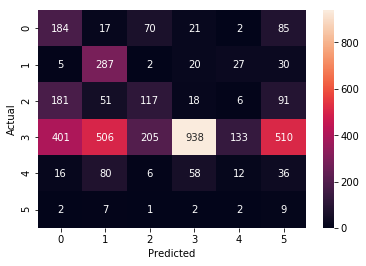

In [16]:
ax = sns.heatmap(confusion_matrix.int(), annot=True, fmt="d")
ax.set(xlabel="Predicted", ylabel="Actual")

In [227]:
bee_data_src.idx_to_key[3]

'healthy'